In [1]:
%env TT_METAL_HOME=/home/ubuntu/tt-metal
%env TT_METAL_RUNTIME_ROOT=/home/ubuntu/tt-metal


env: TT_METAL_HOME=/home/ubuntu/tt-metal
env: TT_METAL_RUNTIME_ROOT=/home/ubuntu/tt-metal


In [2]:
import torch
import torch.nn as nn
model_id = "meta-llama/Llama-3.2-1B-Instruct" 
from transformers import AutoModelForCausalLM, AutoTokenizer
torch_model = AutoModelForCausalLM.from_pretrained(model_id, torch_dtype=torch.bfloat16)
tokenizer = AutoTokenizer.from_pretrained(model_id)

In [3]:
def rel_diff(a, b):
    x = np.abs(a-b) / (np.clip(np.abs(a), a_min=1, a_max=None))
    return x.mean(), x.max()

In [4]:
import numpy as np
import torch
import torch.nn.functional as F
import sys
import ttml

In [5]:
torch_model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((2048,), eps=1e-05)
    (rotary_emb):

In [6]:
class InputOutputSaver(nn.Module):
    def __init__(self, wrapper_module):
        super().__init__()
        self.inputs = []
        self.outputs = []
        self.wrapped_module = wrapper_module
        
    def forward(self, *args, **kwargs):
        # Save both positional and keyword arguments
        self.inputs.append({
            'args': args,
            'kwargs': kwargs
        })
        
        # Forward pass
        output = self.wrapped_module(*args, **kwargs)
        
        # Save output (handles single values, tuples, lists, dicts, etc.)
        self.outputs.append(output)
        
        return output
    
    def clear_history(self):
        """Clear saved inputs and outputs"""
        self.inputs = []
        self.outputs = []
    
    def get_last_input(self):
        """Get the most recent input"""
        return self.inputs[-1] if self.inputs else None
    
    def get_last_output(self):
        """Get the most recent output"""
        return self.outputs[-1] if self.outputs else None
    

torch_model.model.layers[10].self_attn = InputOutputSaver(torch_model.model.layers[10].self_attn)
layer = torch_model.model.layers[10].self_attn

In [7]:
OUTPUT_TOKENS = 1
WITH_SAMPLING = True
TEMPERATURE = 0.7
def generate_with_pytorch(torch_model, prompt_tokens):
    import time
    import torch.nn.functional as F
    from transformers import DynamicCache
    
    torch_model.eval()
    
    print("************************************")
    # Convert list to tensor and add batch dimension
    if isinstance(prompt_tokens, list):
        prompt_tokens = torch.tensor([prompt_tokens])
    
    start_time = time.time()
    
    # Initialize KV cache using the new DynamicCache API
    past_key_values = DynamicCache()
    input_ids = prompt_tokens
    
    with torch.no_grad():
        for i in range(OUTPUT_TOKENS):
            # Get model outputs with KV cache
            outputs = torch_model(
                input_ids=input_ids,
                past_key_values=past_key_values,
                use_cache=True
            )
            logits = outputs.logits
            past_key_values = outputs.past_key_values
            
            # Get logits for the last token
            next_token_logits = logits[:, -1, :]
            
            # Apply temperature and sample
            if WITH_SAMPLING and TEMPERATURE > 0:
                next_token_logits = next_token_logits / TEMPERATURE
                probs = F.softmax(next_token_logits, dim=-1)
                next_token = torch.multinomial(probs, num_samples=1)
            else:
                # Greedy sampling
                next_token = torch.argmax(next_token_logits, dim=-1, keepdim=True)
            
            # Decode and print the token
            output = tokenizer.decode(next_token[0])
            print(output, end='', flush=True)
            
            # For next iteration, only pass the new token (KV cache handles the rest)
            input_ids = next_token
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    tokens_per_second = OUTPUT_TOKENS / elapsed_time
    
    print(f"\n************************************")
    print(f"Generated {OUTPUT_TOKENS} tokens in {elapsed_time:.2f} seconds")
    print(f"Performance: {tokens_per_second:.2f} tokens/second")
    print("************************************\n\n")
prompt_str = "starting with more efficient tokenizer"

prompt_tokens = tokenizer.encode(prompt_str)
generate_with_pytorch(torch_model, prompt_tokens)

************************************


************************************
Generated 1 tokens in 0.90 seconds
Performance: 1.11 tokens/second
************************************




In [8]:
layer.wrapped_module.num_key_value_groups, layer.wrapped_module.head_dim

(4, 64)

In [9]:
import numpy as np
import torch
import torch.nn.functional as F
import sys
import ttml

torch.manual_seed(42)
np.random.seed(42)

In [10]:
layer.get_last_input()['kwargs']['hidden_states']

tensor([[[ 0.0018, -0.0091,  0.0354,  ..., -0.0070,  0.0339, -0.0012],
         [-0.0879, -0.4395,  0.2139,  ..., -0.0383, -0.0278, -0.4414],
         [-0.8672,  0.1924, -0.1064,  ...,  0.4512, -0.5586, -0.1670],
         [-0.2373,  0.1953, -0.6953,  ...,  0.3125,  0.2695,  0.3203],
         [-0.4648, -0.2227, -0.6289,  ...,  0.0396,  0.2637,  0.2061],
         [-0.4375, -0.1709,  0.2832,  ...,  0.0679,  0.4746,  0.3828]]],
       dtype=torch.bfloat16)

In [11]:
layer.get_last_input()['kwargs']['cache_position']

tensor([0, 1, 2, 3, 4, 5])

In [12]:
rope_theta = torch_model.config.rope_theta

In [13]:
import torch
import numpy as np

def generate_rope_embeddings(positions, head_dim, theta):
    """
    Generate RoPE sin/cos embeddings for given positions
    
    positions: tensor of position indices, e.g. [0, 1, 2]
    head_dim: dimension of each head (64 for Llama)
    theta: RoPE base frequency (500000 for Llama 3.2)
    
    Returns: (cos, sin) tensors of shape [1, len(positions), head_dim]
    """
    inv_freq = 1.0 / (theta ** (torch.arange(0, head_dim, 2, dtype=torch.float32) / head_dim))
    
    positions = positions.float()
    freqs = torch.outer(positions, inv_freq)
    
    emb = torch.cat([freqs, freqs], dim=-1)
    
    cos = emb.cos()
    sin = emb.sin()
    
    return cos.unsqueeze(0), sin.unsqueeze(0)

positions = layer.get_last_input()['kwargs']['cache_position'] # [0, 1, 2, ..]
cos_generated, sin_generated = generate_rope_embeddings(positions, layer.wrapped_module.head_dim, rope_theta)
print("Generated cos shape:", cos_generated.shape)
print("Generated sin shape:", sin_generated.shape)

cos_from_layer, sin_from_layer = layer.get_last_input()['kwargs']['position_embeddings']
print("\nFrom layer cos shape:", cos_from_layer.shape)
print("From layer sin shape:", sin_from_layer.shape)

print("\nCos match:", (cos_generated - cos_from_layer).abs().max())
print("Sin match:", (sin_generated - sin_from_layer).abs().max())

Generated cos shape: torch.Size([1, 6, 64])
Generated sin shape: torch.Size([1, 6, 64])

From layer cos shape: torch.Size([1, 6, 64])
From layer sin shape: torch.Size([1, 6, 64])

Cos match: tensor(0.0019)
Sin match: tensor(0.0049)


In [14]:
cos_from_layer.shape, cos_generated.shape

(torch.Size([1, 6, 64]), torch.Size([1, 6, 64]))

In [15]:
layer.get_last_input()['kwargs']['cache_position'].unsqueeze(1).shape

torch.Size([6, 1])

In [16]:
from transformers.models.llama.modeling_llama import apply_rotary_pos_emb

In [17]:
batch, seq_len = 1, cos_from_layer.shape[1]
hidden_size = torch_model.config.hidden_size
num_heads = torch_model.config.num_attention_heads
num_kv_heads = torch_model.config.num_key_value_heads
head_dim = layer.wrapped_module.head_dim

hidden_pt = layer.get_last_input()['kwargs']['hidden_states']
q_weight_pt = layer.wrapped_module.q_proj.weight.data
k_weight_pt = layer.wrapped_module.k_proj.weight.data
v_weight_pt = layer.wrapped_module.v_proj.weight.data
o_weight_pt = layer.wrapped_module.o_proj.weight.data

query_pt_flat = F.linear(hidden_pt, q_weight_pt)
key_pt_flat = F.linear(hidden_pt, k_weight_pt)
value_pt_flat = F.linear(hidden_pt, v_weight_pt)

query_pt = query_pt_flat.view(batch, seq_len, num_heads, head_dim).transpose(1, 2)
key_pt = key_pt_flat.view(batch, seq_len, num_kv_heads, head_dim).transpose(1, 2)
value_pt = value_pt_flat.view(batch, seq_len, num_kv_heads, head_dim).transpose(1, 2)

cos, sin = layer.get_last_input()['kwargs']['position_embeddings']

query_pt_emb, key_pt_emb = apply_rotary_pos_emb(query_pt, key_pt, cos, sin)

num_groups = num_heads // num_kv_heads

print(query_pt.shape, key_pt.shape, value_pt.shape)

key_pt_r = key_pt_emb.repeat_interleave(num_groups, dim=1)
value_pt_r = value_pt.repeat_interleave(num_groups, dim=1)

print(query_pt.shape, key_pt.shape, value_pt.shape)
attn_output_pt = F.scaled_dot_product_attention(query_pt_emb, key_pt_r, value_pt_r, is_causal=True)

attn_output_pt_reshaped = attn_output_pt.transpose(1, 2).contiguous().view(batch, seq_len, -1)
output_pt = F.linear(attn_output_pt_reshaped, o_weight_pt)
rel_diff(layer.get_last_output()[0].float().numpy(), output_pt.float().numpy())

torch.Size([1, 32, 6, 64]) torch.Size([1, 8, 6, 64]) torch.Size([1, 8, 6, 64])
torch.Size([1, 32, 6, 64]) torch.Size([1, 8, 6, 64]) torch.Size([1, 8, 6, 64])


(0.0, 0.0)

In [21]:
hidden_ttml = ttml.autograd.Tensor.from_numpy(
    hidden_pt.float().reshape(batch, 1, seq_len, hidden_size).numpy(),
    ttml.Layout.TILE,
    ttml.autograd.DataType.BFLOAT16
)

q_weight_ttml = ttml.autograd.Tensor.from_numpy(
    q_weight_pt.float().reshape(1, 1, num_heads * head_dim, hidden_size).numpy(),
    ttml.Layout.TILE,
    ttml.autograd.DataType.BFLOAT16
)
k_weight_ttml = ttml.autograd.Tensor.from_numpy(
    k_weight_pt.float().reshape(1, 1, num_kv_heads * head_dim, hidden_size).numpy(),
    ttml.Layout.TILE,
    ttml.autograd.DataType.BFLOAT16
)
v_weight_ttml = ttml.autograd.Tensor.from_numpy(
    v_weight_pt.float().reshape(1, 1, num_kv_heads * head_dim, hidden_size).numpy(),
    ttml.Layout.TILE,
    ttml.autograd.DataType.BFLOAT16
)
o_weight_ttml = ttml.autograd.Tensor.from_numpy(
    o_weight_pt.float().reshape(1, 1, hidden_size, num_heads * head_dim).numpy(),
    ttml.Layout.TILE,
    ttml.autograd.DataType.BFLOAT16
)

q_proj = ttml.ops.matmul.matmul_op(hidden_ttml, q_weight_ttml, transpose_a=False, transpose_b=True)
k_proj = ttml.ops.matmul.matmul_op(hidden_ttml, k_weight_ttml, transpose_a=False, transpose_b=True)
v_proj = ttml.ops.matmul.matmul_op(hidden_ttml, v_weight_ttml, transpose_a=False, transpose_b=True)


#q_proj = ttml.ops.linear.linear_op(hidden_ttml, q_weight_ttml, q_weight_ttml)


2025-12-29 23:04:03.674 | info     |             UMD | Starting topology discovery. (topology_discovery.cpp:69)
2025-12-29 23:04:03.679 | info     |             UMD | Established firmware bundle version: 80.17.0 (topology_discovery.cpp:363)
2025-12-29 23:04:03.679 | info     |             UMD | Established ETH FW version: 6.14.0 (topology_discovery_wormhole.cpp:324)
2025-12-29 23:04:03.680 | info     |             UMD | Completed topology discovery. (topology_discovery.cpp:73)
2025-12-29 23:04:03.680 | info     |          Device | Opening user mode device driver (tt_cluster.cpp:214)
2025-12-29 23:04:03.681 | info     |             UMD | Starting topology discovery. (topology_discovery.cpp:69)
2025-12-29 23:04:03.685 | info     |             UMD | Established firmware bundle version: 80.17.0 (topology_discovery.cpp:363)
2025-12-29 23:04:03.685 | info     |             UMD | Established ETH FW version: 6.14.0 (topology_discovery_wormhole.cpp:324)
2025-12-29 23:04:03.685 | info     |     

In [22]:
def unpermute_proj_rows(w, n_heads):
    rows, cols = w.shape
    if rows % n_heads != 0:
        raise RuntimeError(f"unpermute_proj_rows: rows {rows} not divisible by n_heads {n_heads}")
    
    D = rows // n_heads
    if D % 2 != 0:
        raise RuntimeError(f"unpermute_proj_rows: rows per head {D} must be even")
    
    return w.view(n_heads, 2, D // 2, cols).transpose(1, 2).reshape(rows, cols)

q_weight_unpermuted = unpermute_proj_rows(q_weight_pt.float(), num_heads)
k_weight_unpermuted = unpermute_proj_rows(k_weight_pt.float(), num_kv_heads)

hidden_ttml = ttml.autograd.Tensor.from_numpy(
    hidden_pt.float().reshape(batch, 1, seq_len, hidden_size).numpy(),
    ttml.Layout.TILE,
    ttml.autograd.DataType.BFLOAT16
)
q_weight_ttml = ttml.autograd.Tensor.from_numpy(
    q_weight_unpermuted.reshape(1, 1, num_heads * head_dim, hidden_size).numpy(),
    ttml.Layout.TILE,
    ttml.autograd.DataType.BFLOAT16
)
k_weight_ttml = ttml.autograd.Tensor.from_numpy(
    k_weight_unpermuted.reshape(1, 1, num_kv_heads * head_dim, hidden_size).numpy(),
    ttml.Layout.TILE,
    ttml.autograd.DataType.BFLOAT16
)
v_weight_ttml = ttml.autograd.Tensor.from_numpy(
    v_weight_pt.float().reshape(1, 1, num_kv_heads * head_dim, hidden_size).numpy(),
    ttml.Layout.TILE,
    ttml.autograd.DataType.BFLOAT16
)
o_weight_ttml = ttml.autograd.Tensor.from_numpy(
    o_weight_pt.float().reshape(1, 1, hidden_size, num_heads * head_dim).numpy(),
    ttml.Layout.TILE,
    ttml.autograd.DataType.BFLOAT16
)

In [23]:
q_proj = ttml.ops.matmul.matmul_op(hidden_ttml, q_weight_ttml, transpose_a=False, transpose_b=True)
k_proj = ttml.ops.matmul.matmul_op(hidden_ttml, k_weight_ttml, transpose_a=False, transpose_b=True)
v_proj = ttml.ops.matmul.matmul_op(hidden_ttml, v_weight_ttml, transpose_a=False, transpose_b=True)



In [24]:
#q_proj = ttml.ops.linear.linear_op(hidden_ttml, q_weight_ttml, None)

In [25]:
rel_diff(query_pt_flat.float().numpy(), q_proj.to_numpy())

(0.79649335, 10.763672)

In [26]:
rel_diff(key_pt_flat.float().numpy(), k_proj.to_numpy())

(1.1202292, 8.875)

In [27]:
rel_diff(value_pt_flat.float().numpy(), v_proj.to_numpy())

(9.672748e-05, 0.00729927)

In [28]:
kv_proj = ttml.ops.concat([k_proj, v_proj], 3)
query_ttml, key_ttml, value_ttml = ttml.ops.multi_head_utils.grouped_heads_creation(
    q_proj, kv_proj, num_heads, num_kv_heads
)

In [29]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import math


def compare_tensors_with_viz(tensor1, tensor2, save_path="tensor_diff.png", show=True):
    tensor1 = tensor1.detach().cpu()
    tensor2 = tensor2.detach().cpu()
    
    if tensor1.shape != tensor2.shape:
        raise ValueError(f"Tensor shapes must match: {tensor1.shape} vs {tensor2.shape}")
    
    abs_diff = torch.abs(tensor1 - tensor2)
    max_abs = torch.maximum(torch.abs(tensor1), torch.abs(tensor2))
    relative_diff = abs_diff / (max_abs + 1.0)
    
    top5_values, top5_indices = torch.topk(relative_diff.flatten(), min(5, relative_diff.numel()))
    
    print("Top 5 relative differences:")
    for i, (val, idx) in enumerate(zip(top5_values, top5_indices)):
        multi_idx = np.unravel_index(idx.item(), relative_diff.shape)
        print(f"  {i+1}. Value: {val.item():.6e} at index {multi_idx}")
    
    diff_flat = relative_diff.flatten()
    n = diff_flat.numel()
    
    side = math.ceil(math.sqrt(n))
    total_size = side * side
    
    if n < total_size:
        padding = torch.zeros(total_size - n)
        diff_flat = torch.cat([diff_flat, padding])
    
    diff_2d = diff_flat.reshape(side, side)
    
    plt.figure(figsize=(10, 8))
    im = plt.imshow(diff_2d.numpy(), cmap='hot', interpolation='nearest', vmin=0, vmax=0.05)
    plt.colorbar(im, label='Relative Difference')
    plt.title(f'Tensor Relative Difference (scale: 0-5%)\nOriginal shape: {tensor1.shape}, Reshaped to: {diff_2d.shape}')
    plt.xlabel('Column')
    plt.ylabel('Row')
    
    #plt.savefig(save_path, dpi=150, bbox_inches='tight')
    #print(f"\nImage saved to: {save_path}")
    
    if show:
        plt.show()
    else:
        plt.close()
    
    return relative_diff, diff_2d


In [30]:
# q shape: Shape([1, 1, 2048, 2048])
# kv shape: Shape([1, 1, 2048, 1024])
# query_with_heads shape: Shape([1, 32, 2048, 64])
# key_with_heads shape: Shape([1, 8, 2048, 64])
# value_with_heads shape: Shape([1, 8, 2048, 64])

In [31]:
query_ttml.shape(), key_ttml.shape(), value_ttml.shape()

([1, 32, 6, 64], [1, 8, 6, 64], [1, 8, 6, 64])

In [32]:
rel_diff(query_pt.float().numpy(), query_ttml.to_numpy())

(0.7964935, 10.763672)

Top 5 relative differences:
  1. Value: 1.603550e+00 at index (0, 23, 5, 62)
  2. Value: 1.564189e+00 at index (0, 20, 5, 62)
  3. Value: 1.545455e+00 at index (0, 23, 5, 59)
  4. Value: 1.527472e+00 at index (0, 23, 2, 56)
  5. Value: 1.516393e+00 at index (0, 23, 4, 62)


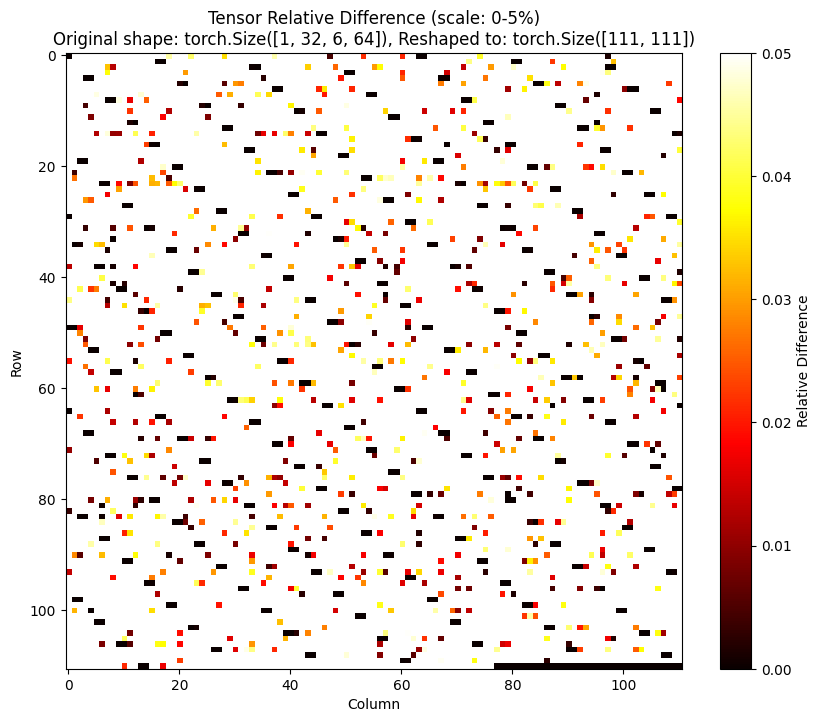

In [34]:
_ = compare_tensors_with_viz(query_pt.float(), torch.from_numpy(query_ttml.to_numpy().astype(np.float32)))

Top 5 relative differences:
  1. Value: 1.672414e+00 at index (0, 1, 2, 49)
  2. Value: 1.665370e+00 at index (0, 1, 3, 49)
  3. Value: 1.603687e+00 at index (0, 1, 4, 49)
  4. Value: 1.601896e+00 at index (0, 1, 1, 49)
  5. Value: 1.589286e+00 at index (0, 6, 4, 30)


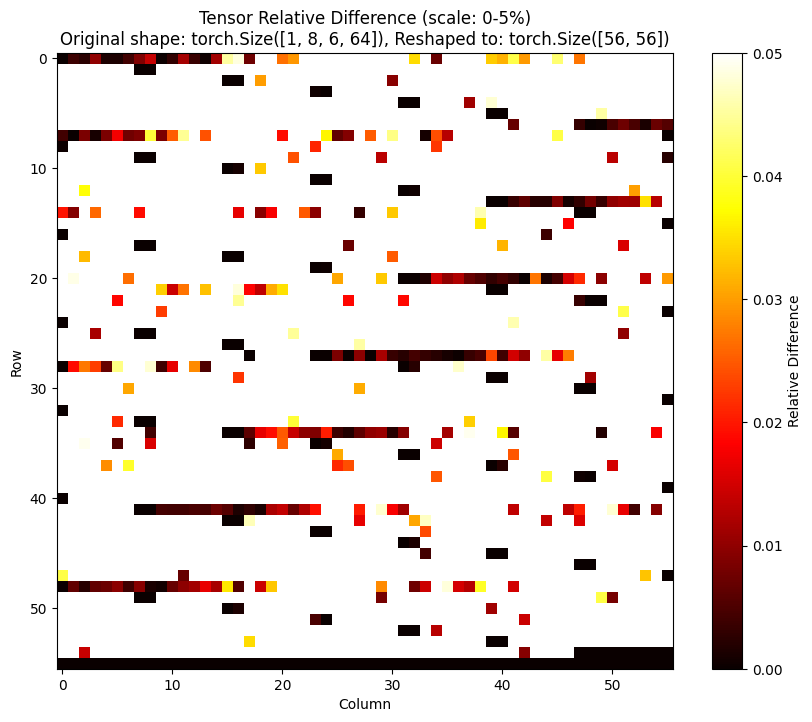

In [35]:
_ = compare_tensors_with_viz(key_pt.float(), torch.from_numpy(key_ttml.to_numpy().astype(np.float32)))

Top 5 relative differences:
  1. Value: 3.773585e-03 at index (0, 5, 3, 54)
  2. Value: 3.676471e-03 at index (0, 0, 5, 17)
  3. Value: 3.484321e-03 at index (0, 3, 1, 5)
  4. Value: 3.311258e-03 at index (0, 0, 1, 0)
  5. Value: 2.557545e-03 at index (0, 2, 4, 40)


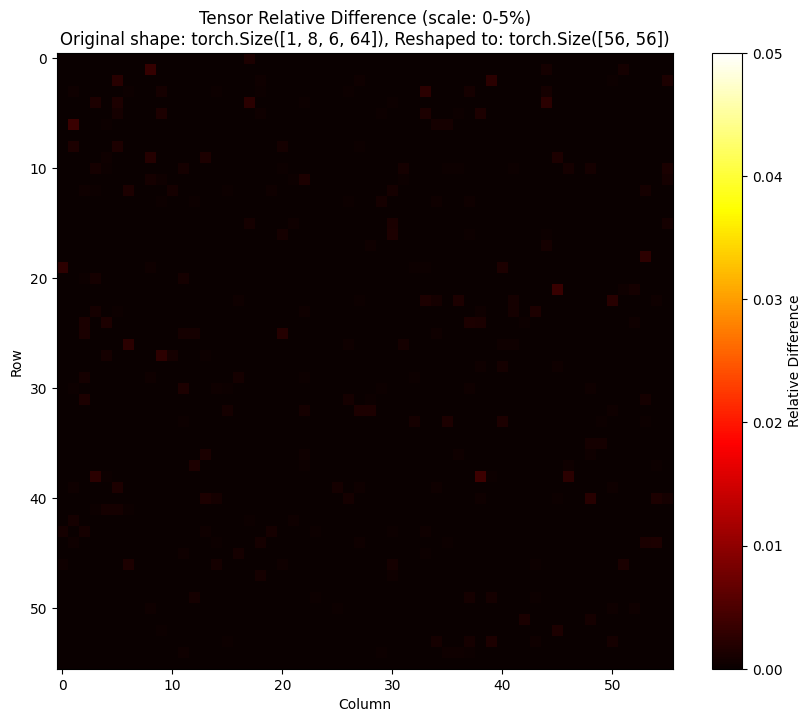

In [36]:
_ = compare_tensors_with_viz(value_pt.float(), torch.from_numpy(value_ttml.to_numpy().astype(np.float32)))

In [37]:
rel_diff(query_pt.float().numpy(), query_ttml.to_numpy())

(0.7964935, 10.763672)

In [38]:
rel_diff(key_pt.float().numpy(), key_ttml.to_numpy())

(1.1202292, 8.875)

In [39]:
rel_diff(value_pt.float().numpy(), value_ttml.to_numpy())

(9.6727475e-05, 0.00729927)

In [40]:
rope_params = ttml.ops.rope.build_rope_params(seq_len, head_dim, rope_theta)
query_ttml_emb = ttml.ops.rope.rope(query_ttml, rope_params)
key_ttml_emb = ttml.ops.rope.rope(key_ttml, rope_params)

In [41]:
rel_diff(query_pt_emb.float().numpy(), query_ttml_emb.to_numpy())

(0.79774743, 10.4765625)

In [42]:
rel_diff(query_pt.float().numpy(), query_ttml.to_numpy())

(0.7964935, 10.763672)

In [43]:
causal_mask_binary = np.tril(np.ones((1, 1, seq_len, seq_len), dtype=np.float32))
mask_ttml = ttml.autograd.Tensor.from_numpy(
    causal_mask_binary, ttml.Layout.TILE, ttml.autograd.DataType.BFLOAT16
)

attn_output_ttml = ttml.ops.multi_head_utils.scaled_dot_product_attention(
    query_ttml_emb, key_ttml_emb, value_ttml, mask_ttml
)

In [44]:
rel_diff(attn_output_pt.float().numpy(), attn_output_ttml.to_numpy())

(0.00015293258, 0.0078125)

In [45]:
attn_output_ttml = ttml.ops.multi_head_utils.heads_fusion(attn_output_ttml)
output_ttml = ttml.ops.matmul.matmul_op(attn_output_ttml, o_weight_ttml, transpose_a=False, transpose_b=True)
    

In [46]:
rel_diff(output_pt.float().numpy(), output_ttml.to_numpy())

(0.00017755716, 0.00390625)

In [47]:
rel_diff(layer.get_last_output()[0].float().numpy(), output_ttml.to_numpy())

(0.00017755716, 0.00390625)

In [104]:
ttml.ops.layernorm?

************************************
 an "M
************************************
Generated 3 tokens in 0.72 seconds
Performance: 4.15 tokens/second
************************************




In [13]:
torch_model.model.layers[10].inputs[0]['args']

(tensor([[[ 0.0615, -0.2949,  1.4531,  ..., -0.2402,  1.0703, -0.0439],
          [-0.0266, -0.1270,  0.0781,  ..., -0.0116, -0.0078, -0.1406],
          [-0.2490,  0.0522, -0.0366,  ...,  0.1289, -0.1475, -0.0503]]],
        dtype=torch.bfloat16),)

In [14]:
torch_model.model.layers[10].inputs[0]['args']

(tensor([[[ 0.0615, -0.2949,  1.4531,  ..., -0.2402,  1.0703, -0.0439],
          [-0.0266, -0.1270,  0.0781,  ..., -0.0116, -0.0078, -0.1406],
          [-0.2490,  0.0522, -0.0366,  ...,  0.1289, -0.1475, -0.0503]]],
        dtype=torch.bfloat16),)

In [15]:
torch_model.model.layers[10].inputs[0]['kwargs']

{'attention_mask': None,
 'position_ids': tensor([[0, 1, 2]]),
 'past_key_value': <transformers.cache_utils.DynamicCache at 0x7feef9def850>,
 'output_attentions': False,
 'use_cache': True,
 'cache_position': tensor([0, 1, 2]),
 'position_embeddings': (tensor([[[ 1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
             1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
             1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
             1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
             1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
             1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
             1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
             1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
             1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
             1.0000],
           [ 0.5391,  0.7891,  0.9062,  0.9570,  0.9

In [11]:

torch_model.model.layers[10].outputs[0]

(tensor([[[ 0.0342, -0.2656,  1.3672,  ..., -0.1836,  0.9570, -0.0444],
          [-0.0275, -0.1475, -0.0132,  ..., -0.1162, -0.0522, -0.1602],
          [-0.0791,  0.0454, -0.0913,  ...,  0.1377, -0.1543, -0.0076]]],
        dtype=torch.bfloat16),)

In [ ]:




def test_llama_attention():
    hidden_ttml = ttml.autograd.Tensor.from_numpy(
        hidden_pt.float().reshape(batch, 1, seq_len, hidden_size).numpy(),
        ttml.Layout.TILE,
        ttml.autograd.DataType.BFLOAT16
    )
    
    q_weight_ttml = ttml.autograd.Tensor.from_numpy(
        q_weight_pt.float().reshape(1, 1, num_heads * head_dim, hidden_size).numpy(),
        ttml.Layout.TILE,
        ttml.autograd.DataType.BFLOAT16
    )
    k_weight_ttml = ttml.autograd.Tensor.from_numpy(
        k_weight_pt.float().reshape(1, 1, num_kv_heads * head_dim, hidden_size).numpy(),
        ttml.Layout.TILE,
        ttml.autograd.DataType.BFLOAT16
    )
    v_weight_ttml = ttml.autograd.Tensor.from_numpy(
        v_weight_pt.float().reshape(1, 1, num_kv_heads * head_dim, hidden_size).numpy(),
        ttml.Layout.TILE,
        ttml.autograd.DataType.BFLOAT16
    )
    o_weight_ttml = ttml.autograd.Tensor.from_numpy(
        o_weight_pt.float().reshape(1, 1, hidden_size, num_heads * head_dim).numpy(),
        ttml.Layout.TILE,
        ttml.autograd.DataType.BFLOAT16
    )
    
    q_proj = ttml.ops.matmul.matmul_op(hidden_ttml, q_weight_ttml, transpose_a=False, transpose_b=True)
    k_proj = ttml.ops.matmul.matmul_op(hidden_ttml, k_weight_ttml, transpose_a=False, transpose_b=True)
    v_proj = ttml.ops.matmul.matmul_op(hidden_ttml, v_weight_ttml, transpose_a=False, transpose_b=True)
    
    print(f"\nLinear projection differences (PyTorch vs TTML):")
    print(f"Q: {np.abs(query_pt_flat.float().numpy().reshape(batch, 1, seq_len, -1) - q_proj.to_numpy()).max():.4f}")
    print(f"K: {np.abs(key_pt_flat.float().numpy().reshape(batch, 1, seq_len, -1) - k_proj.to_numpy()).max():.4f}")
    print(f"V: {np.abs(value_pt_flat.float().numpy().reshape(batch, 1, seq_len, -1) - v_proj.to_numpy()).max():.4f}")
    
    kv_proj = ttml.ops.concat([k_proj, v_proj], 3)
    query_ttml, key_ttml, value_ttml = ttml.ops.multi_head_utils.grouped_heads_creation(
        q_proj, kv_proj, num_heads, num_kv_heads
    )
    
    cos, sin = layer.get_last_input()['kwargs']['position_embeddings']
    rope_params = ttml.build_rope_params(seq_len, head_dim, 500000.0)
    cos_ttml_np = cos.float().numpy().reshape(1, 1, seq_len, head_dim)
    sin_ttml_np = sin.float().numpy().reshape(1, 1, seq_len, head_dim)
    rope_params.cos_cache = ttml.core.from_numpy(cos_ttml_np, ttml.autograd.ctx().get_device())
    rope_params.sin_cache = ttml.core.from_numpy(sin_ttml_np, ttml.autograd.ctx().get_device())
    rope_params.neg_cos_cache = ttml.core.from_numpy(cos_ttml_np, ttml.autograd.ctx().get_device())
    rope_params.neg_sin_cache = ttml.core.from_numpy(-sin_ttml_np, ttml.autograd.ctx().get_device())
    
    query_ttml = ttml.ops.rope.rope(query_ttml, rope_params)
    key_ttml = ttml.ops.rope.rope(key_ttml, rope_params)
    
    print(f"\nQ/K/V differences (PyTorch vs TTML after RoPE):")
    print(f"Q: {np.abs(query_pt_before_gqa.float().numpy() - query_ttml.to_numpy()).max():.4f}")
    print(f"K: {np.abs(key_pt_before_gqa.float().numpy() - key_ttml.to_numpy()).max():.4f}")
    print(f"V: {np.abs(value_pt_before_gqa.float().numpy() - value_ttml.to_numpy()).max():.4f}")
    
    causal_mask_binary = np.tril(np.ones((1, 1, seq_len, seq_len), dtype=np.float32))
    mask_ttml = ttml.autograd.Tensor.from_numpy(
        causal_mask_binary, ttml.Layout.TILE, ttml.autograd.DataType.BFLOAT16
    )
    
    attn_output_ttml = ttml.ops.multi_head_utils.scaled_dot_product_attention(
        query_ttml, key_ttml, value_ttml, mask_ttml
    )
    
    print(f"\nSDPA output: {np.abs(attn_output_pt.float().numpy() - attn_output_ttml.to_numpy()).max():.4f}")
    
    attn_output_ttml = ttml.ops.multi_head_utils.heads_fusion(attn_output_ttml)
    
    output_ttml = ttml.ops.matmul.matmul_op(attn_output_ttml, o_weight_ttml, transpose_a=False, transpose_b=True)
    
    abs_diff = np.abs(output_pt.float().numpy() - output_ttml.to_numpy().reshape(batch, seq_len, hidden_size))
    
    print(f"\nFinal output difference: Max={abs_diff.max():.2f}, Mean={abs_diff.mean():.4f}")
    print(f"\n✓ LlamaAttention implementation complete using TTML operations")
    